In [1]:
import os
import copy
import glob
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torchvision
from fid_score import calculate_fid_given_paths
import sys
import pickle
sys.path.append(os.path.join(os.getcwd(), '..'))
from gan_training import utils
from gan_training.checkpoints import CheckpointIO
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval import Evaluator
from gan_training.config import (load_config, build_models)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
ls=20
fs=24
fig_dir = os.path.join(os.getcwd(), 'evaluation_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Evaluate CIFAR, $\mu=10$

099 29.39 $\pm$ 0.37
099 24.94 $\pm$ 0.25
099 24.14 $\pm$ 0.42
099 24.63 $\pm$ 0.28
0999 27.56 $\pm$ 0.34
0999 23.4 $\pm$ 0.22
0999 22.53 $\pm$ 0.23
0999 23.35 $\pm$ 0.3
09999 26.29 $\pm$ 0.2
09999 22.36 $\pm$ 0.23
09999 21.62 $\pm$ 0.05
09999 22.52 $\pm$ 0.27


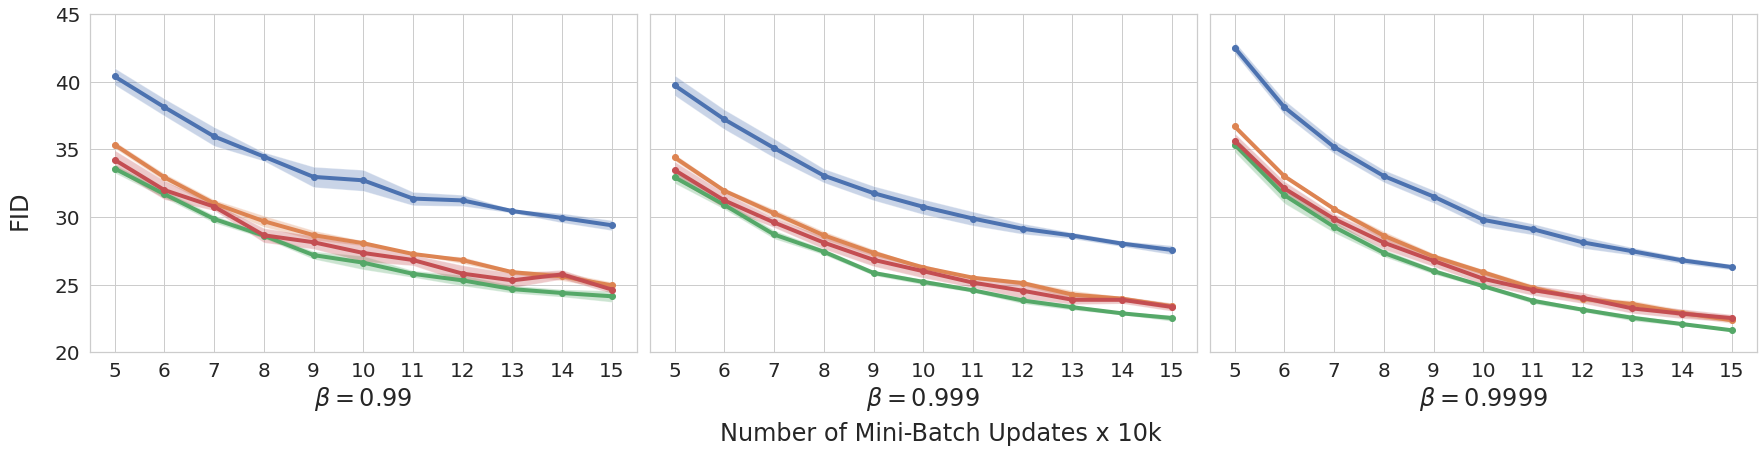

In [2]:
data11 = pickle.load(open('evaluation_data/cifar_sim1_run1/eval_fid.p', 'rb'))
data12 = pickle.load(open('evaluation_data/cifar_sim1_run2/eval_fid.p', 'rb'))
data13 = pickle.load(open('evaluation_data/cifar_sim1_run3/eval_fid.p', 'rb'))

data21 = pickle.load(open('evaluation_data/cifar_sim2_run1/eval_fid.p', 'rb'))
data22 = pickle.load(open('evaluation_data/cifar_sim2_run2/eval_fid.p', 'rb'))
data23 = pickle.load(open('evaluation_data/cifar_sim2_run3/eval_fid.p', 'rb'))

data31 = pickle.load(open('evaluation_data/cifar_sim3_run1/eval_fid.p', 'rb'))
data32 = pickle.load(open('evaluation_data/cifar_sim3_run2/eval_fid.p', 'rb'))
data33 = pickle.load(open('evaluation_data/cifar_sim3_run3/eval_fid.p', 'rb'))

data41 = pickle.load(open('evaluation_data/cifar_sim4_run1/eval_fid.p', 'rb'))
data42 = pickle.load(open('evaluation_data/cifar_sim4_run2/eval_fid.p', 'rb'))
data43 = pickle.load(open('evaluation_data/cifar_sim4_run3/eval_fid.p', 'rb'))


data_list1 = [data11, data12, data13]
data_list2 = [data21, data22, data23]
data_list3 = [data31, data32, data33]
data_list4 = [data41, data42, data43]

data_best_list = []
data_mean_list = []
data_ste_list = []

best_key = (150000, '09999')

for data_list in [data_list1, data_list2, data_list3, data_list4]:
    data_best = data_list[np.argmax([data[best_key]['FID'] for data in data_list])]
    data_best = {key:data_best[key]['FID'] for key in data_best}
    data_mean = {}
    data_ste = {}
    for key in data12.keys():
        data_mean[key] = np.mean([data[key]['FID'] for data in data_list])
        data_ste[key] = np.std([data[key]['FID'] for data in data_list])/np.sqrt(len(data_list))

    data_best_list.append(data_best)
    data_mean_list.append(data_mean)
    data_ste_list.append(data_ste)

data_list = data_mean_list

start = 50000
increment = 10000
end = 160000

betas = ['099', '0999', '09999']

fig, ax = plt.subplots(1, len(betas), figsize=(24, 6), sharey=True, sharex=True)

for j, beta in zip(range(len(betas)), betas):
    for data, data_ste in zip(data_list, data_ste_list):
        x = range(start, end, increment)
        mean = np.array([data[(i, beta)] for i in range(start, end, increment)])
        ste = np.array([data_ste[(i, beta)] for i in range(start, end, increment)])
        print(beta, np.round(mean[-1], 2), '$\pm$', np.round(ste[-1], 2))
        ax[j].plot(x, mean, '-o', lw=4)
        ax[j].fill_between(x, mean-ste, mean+ste, alpha=.3)
        ax[j].set_xticks([item for item in x if item % 10000 == 0])
        temp = np.array(x)
        temp = [str(int(item/10000)) for item in temp if item % 10000 == 0]
        ax[j].set_xticklabels(temp)
        ax[j].set_ylim(20, 45)
        ax[j].set_xlabel(r'$\beta=$'+(beta[0]+'.'+beta[1:]), fontsize=fs)
        ax[j].tick_params(labelsize=ls)
fig.text(0.52, -0.035, 'Number of Mini-Batch Updates x 10k', ha='center', fontsize=fs)
fig.text(-0.02, 0.5, 'FID', va='center', rotation='vertical', fontsize=fs)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cifar_fid_reg10.png'), bbox_inches='tight')
plt.show()

## Evaluate CIFAR-10, $\mu=1$

099 28.1 $\pm$ 0.52
099 23.49 $\pm$ 0.49
099 22.35 $\pm$ 0.15
099 22.46 $\pm$ 0.37
0999 26.18 $\pm$ 0.54
0999 22.0 $\pm$ 0.38
0999 20.71 $\pm$ 0.06
0999 21.36 $\pm$ 0.44
09999 24.6 $\pm$ 0.3
09999 21.05 $\pm$ 0.38
09999 19.49 $\pm$ 0.06
09999 20.27 $\pm$ 0.4


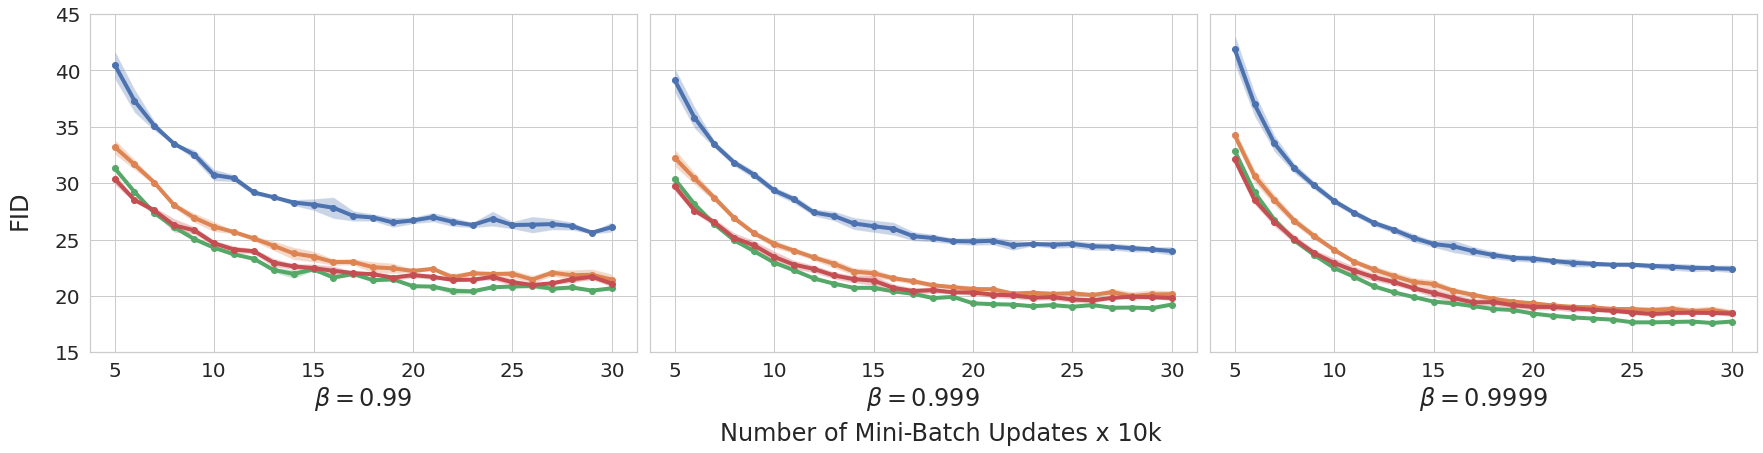

In [27]:
data11 = pickle.load(open('evaluation_data/cifar_sim1_run1_reg1/eval_fid.p', 'rb'))
data21 = pickle.load(open('evaluation_data/cifar_sim2_run1_reg1/eval_fid.p', 'rb'))
data31 = pickle.load(open('evaluation_data/cifar_sim3_run1_reg1/eval_fid.p', 'rb'))
data41 = pickle.load(open('evaluation_data/cifar_sim4_run1_reg1/eval_fid.p', 'rb'))

data12 = pickle.load(open('evaluation_data/cifar_sim1_run2_reg1/eval_fid.p', 'rb'))
data22 = pickle.load(open('evaluation_data/cifar_sim2_run2_reg1/eval_fid.p', 'rb'))
data32 = pickle.load(open('evaluation_data/cifar_sim3_run2_reg1/eval_fid.p', 'rb'))
data42 = pickle.load(open('evaluation_data/cifar_sim4_run2_reg1/eval_fid.p', 'rb'))

data13 = pickle.load(open('evaluation_data/cifar_sim1_run3_reg1/eval_fid.p', 'rb'))
data23 = pickle.load(open('evaluation_data/cifar_sim2_run3_reg1/eval_fid.p', 'rb'))
data33 = pickle.load(open('evaluation_data/cifar_sim3_run3_reg1/eval_fid.p', 'rb'))
data43 = pickle.load(open('evaluation_data/cifar_sim4_run3_reg1/eval_fid.p', 'rb'))

data_list1 = [data11, data12, data13]
data_list2 = [data21, data22, data23]
data_list3 = [data31, data32, data33]
data_list4 = [data41, data42, data43]

data_best_list = []
data_mean_list = []
data_ste_list = []

best_key = (300000, '09999')

for data_list in [data_list1, data_list2, data_list3, data_list4]:
    data_best = data_list[np.argmax([data[best_key]['FID'] for data in data_list])]
    data_best = {key:data_best[key]['FID'] for key in data_best}
    data_mean = {}
    data_ste = {}
    for key in data12.keys():
        data_mean[key] = np.mean([data[key]['FID'] for data in data_list])
        data_ste[key] = np.std([data[key]['FID'] for data in data_list])/np.sqrt(len(data_list))

    data_best_list.append(data_best)
    data_mean_list.append(data_mean)
    data_ste_list.append(data_ste)

data_list = data_mean_list

start = 50000
increment = 10000
end = 310000
ylim = [15, 45]

betas = ['099', '0999', '09999']

fig, ax = plt.subplots(1, len(betas), figsize=(24, 6), sharey=True, sharex=True)

for j, beta in zip(range(len(betas)), betas):
    for data, data_ste in zip(data_list, data_ste_list):
        x = range(start, end, increment)
        mean = np.array([data[(i, beta)] for i in range(start, end, increment)])
        ste = np.array([data_ste[(i, beta)] for i in range(start, end, increment)])
        #print(beta, np.round(mean[-1], 2), '$\pm$', np.round(ste[-1], 2))
        print(beta, np.round(mean[10], 2), '$\pm$', np.round(ste[10], 2))
        ax[j].plot(x, mean, '-o', lw=4)
        ax[j].fill_between(x, mean-ste, mean+ste, alpha=.3)
        ax[j].set_xticks([item for item in x if item % 50000 == 0])
        temp = np.array(x)
        temp = [str(int(item/10000)) for item in temp if item % 50000 == 0]
        ax[j].set_xticklabels(temp)
        ax[j].set_ylim(ylim)
        ax[j].set_xlabel(r'$\beta=$'+(beta[0]+'.'+beta[1:]), fontsize=fs)
        ax[j].tick_params(labelsize=ls)
fig.text(0.52, -0.035, 'Number of Mini-Batch Updates x 10k', ha='center', fontsize=fs)
fig.text(-0.02, 0.5, 'FID', va='center', rotation='vertical', fontsize=fs)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cifar_fid_reg1.png'), bbox_inches='tight')
plt.show()

## Evaluate CelebA, $\mu=10$

099 7.42 $\pm$ 0.097
099 6.26 $\pm$ 0.064
099 6.34 $\pm$ 0.034
099 7.01 $\pm$ 0.089
0999 7.01 $\pm$ 0.091
0999 6.04 $\pm$ 0.021
0999 5.97 $\pm$ 0.025
0999 6.69 $\pm$ 0.088
09999 7.07 $\pm$ 0.079
09999 6.05 $\pm$ 0.014
09999 5.93 $\pm$ 0.002
09999 6.43 $\pm$ 0.043


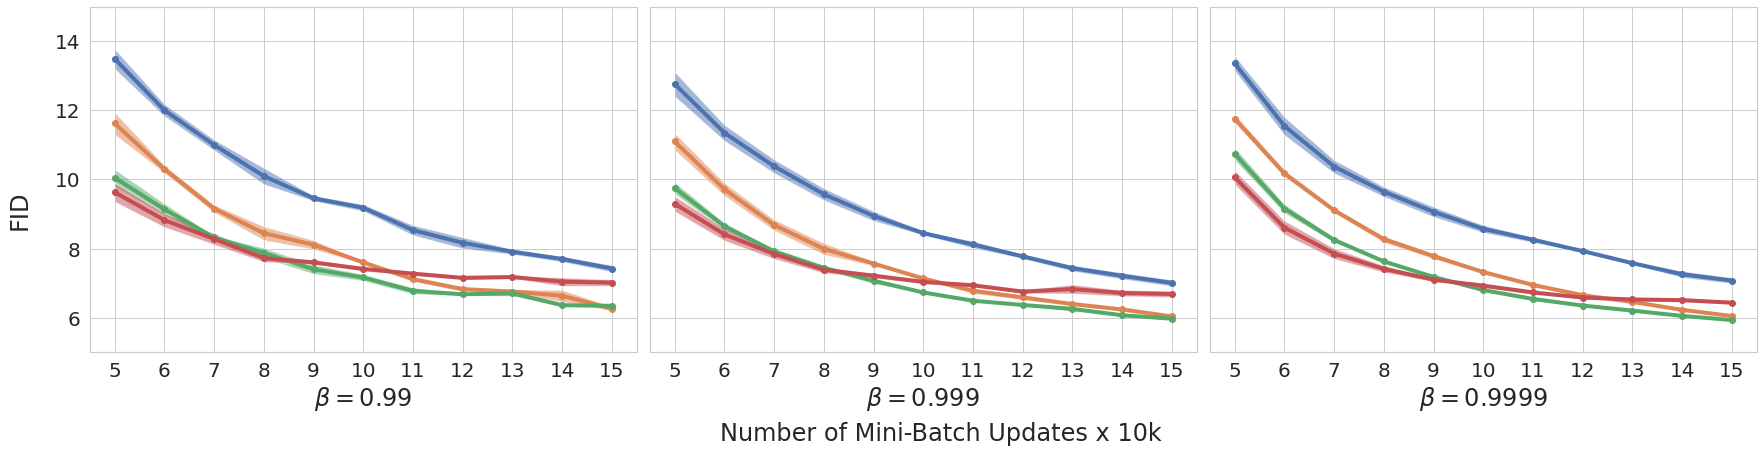

In [31]:
data11 = pickle.load(open('evaluation_data/celeba_sim1_run1/eval_fid.p', 'rb'))
data12 = pickle.load(open('evaluation_data/celeba_sim1_run2/eval_fid.p', 'rb'))
data13 = pickle.load(open('evaluation_data/celeba_sim1_run3/eval_fid.p', 'rb'))

data21 = pickle.load(open('evaluation_data/celeba_sim2_run1/eval_fid.p', 'rb'))
data22 = pickle.load(open('evaluation_data/celeba_sim2_run2/eval_fid.p', 'rb'))
data23 = pickle.load(open('evaluation_data/celeba_sim2_run3/eval_fid.p', 'rb'))

data31 = pickle.load(open('evaluation_data/celeba_sim3_run1/eval_fid.p', 'rb'))
data32 = pickle.load(open('evaluation_data/celeba_sim3_run2/eval_fid.p', 'rb'))
data33 = pickle.load(open('evaluation_data/celeba_sim3_run3/eval_fid.p', 'rb'))

data41 = pickle.load(open('evaluation_data/celeba_sim4_run1/eval_fid.p', 'rb'))
data42 = pickle.load(open('evaluation_data/celeba_sim4_run2/eval_fid.p', 'rb'))
data43 = pickle.load(open('evaluation_data/celeba_sim4_run3/eval_fid.p', 'rb'))

data_list1 = [data11, data12, data13]
data_list2 = [data21, data22, data23]
data_list3 = [data31, data32, data33]
data_list4 = [data41, data42, data43]

data_best_list = []
data_mean_list = []
data_ste_list = []

best_key = (150000, '09999')

for data_list in [data_list1, data_list2, data_list3, data_list4]:
    data_best = data_list[np.argmax([data[best_key]['FID'] for data in data_list])]
    data_best = {key:data_best[key]['FID'] for key in data_best}
    data_mean = {}
    data_ste = {}
    for key in data12.keys():
        data_mean[key] = np.mean([data[key]['FID'] for data in data_list])
        data_ste[key] = np.std([data[key]['FID'] for data in data_list])/np.sqrt(len(data_list))

    data_best_list.append(data_best)
    data_mean_list.append(data_mean)
    data_ste_list.append(data_ste)

data_list = data_mean_list

start = 50000
increment = 10000
end = 160000
betas = ['099', '0999', '09999']

fig, ax = plt.subplots(1, len(betas), figsize=(24, 6), sharey=True, sharex=True)

for j, beta in zip(range(len(betas)), betas):
    for data, data_ste in zip(data_list, data_ste_list):
        x = range(start, end, increment)
        mean = np.array([data[(i, beta)] for i in range(start, end, increment)])
        ste = np.array([data_ste[(i, beta)] for i in range(start, end, increment)])
        print(beta, np.round(mean[-1], 2), '$\pm$', np.round(ste[-1], 3))
        ax[j].plot(x, mean, '-o', lw=4)
        ax[j].fill_between(x, mean-ste, mean+ste, alpha=.5)
        ax[j].set_xticks([item for item in x if item % 10000 == 0])
        temp = np.array(x)
        temp = [str(int(item/10000)) for item in temp if item % 10000 == 0]
        ax[j].set_xticklabels(temp)
        ax[j].set_ylim(5, 15)
        ax[j].set_xlabel(r'$\beta=$'+(beta[0]+'.'+beta[1:]), fontsize=fs)
        ax[j].tick_params(labelsize=ls)
fig.text(0.52, -0.035, 'Number of Mini-Batch Updates x 10k', ha='center', fontsize=fs)
fig.text(-0.02, 0.5, 'FID', va='center', rotation='vertical', fontsize=fs)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'celeba_fid_reg10.png'), bbox_inches='tight')
plt.show()

## Evaluate CelebA, $\mu=1$

099 7.22 $\pm$ 0.15
099 5.93 $\pm$ 0.12
099 5.8 $\pm$ 0.04
099 5.88 $\pm$ 0.05
0999 6.87 $\pm$ 0.17
0999 5.69 $\pm$ 0.03
0999 5.51 $\pm$ 0.04
0999 5.68 $\pm$ 0.03
09999 7.01 $\pm$ 0.22
09999 5.86 $\pm$ 0.04
09999 5.59 $\pm$ 0.06
09999 5.7 $\pm$ 0.05


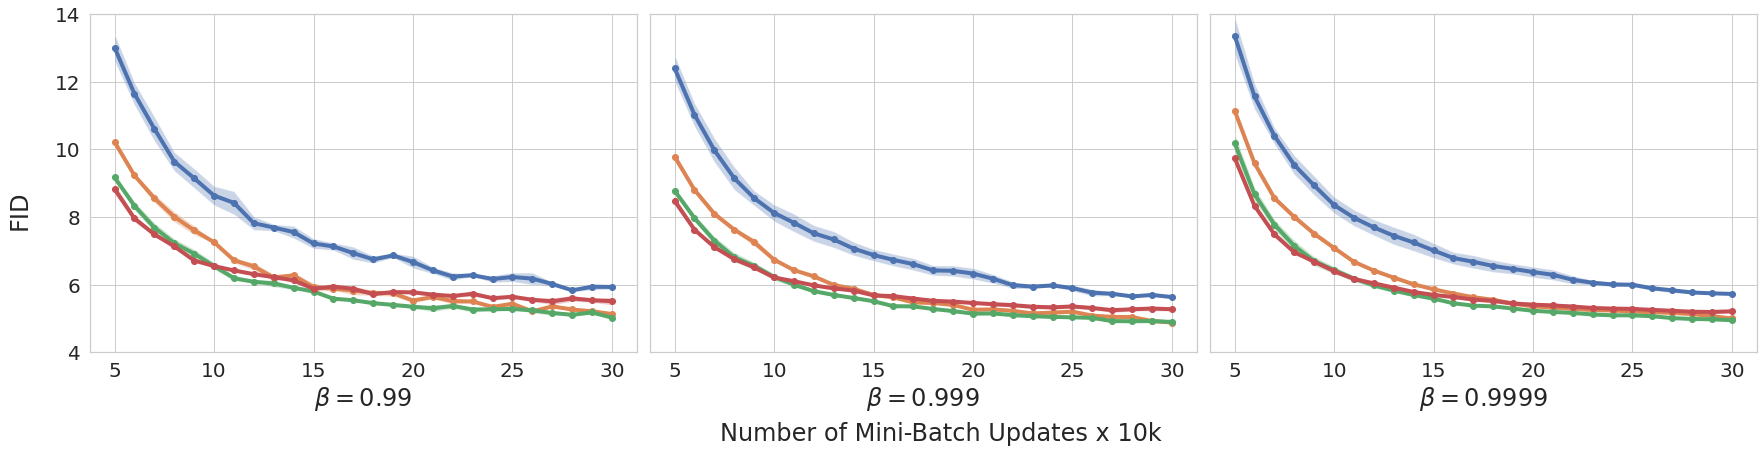

In [32]:
data11 = pickle.load(open('evaluation_data/celeba_sim1_run1_reg1/eval_fid.p', 'rb'))
data21 = pickle.load(open('evaluation_data/celeba_sim2_run1_reg1/eval_fid.p', 'rb'))
data31 = pickle.load(open('evaluation_data/celeba_sim3_run1_reg1/eval_fid.p', 'rb'))
data41 = pickle.load(open('evaluation_data/celeba_sim4_run1_reg1/eval_fid.p', 'rb'))

data12 = pickle.load(open('evaluation_data/celeba_sim1_run2_reg1/eval_fid.p', 'rb'))
data22 = pickle.load(open('evaluation_data/celeba_sim2_run2_reg1/eval_fid.p', 'rb'))
data32 = pickle.load(open('evaluation_data/celeba_sim3_run2_reg1/eval_fid.p', 'rb'))
data42 = pickle.load(open('evaluation_data/celeba_sim4_run2_reg1/eval_fid.p', 'rb'))

data13 = pickle.load(open('evaluation_data/celeba_sim1_run3_reg1/eval_fid.p', 'rb'))
data23 = pickle.load(open('evaluation_data/celeba_sim2_run3_reg1/eval_fid.p', 'rb'))
data33 = pickle.load(open('evaluation_data/celeba_sim3_run3_reg1/eval_fid.p', 'rb'))
data43 = pickle.load(open('evaluation_data/celeba_sim4_run3_reg1/eval_fid.p', 'rb'))

data_list1 = [data11, data12, data13]
data_list2 = [data21, data22, data23]
data_list3 = [data31, data32, data33]
data_list4 = [data41, data42, data43]

data_best_list = []
data_mean_list = []
data_ste_list = []

best_key = (300000, '09999')

for data_list in [data_list1, data_list2, data_list3, data_list4]:
    data_best = data_list[np.argmax([data[best_key]['FID'] for data in data_list])]
    data_best = {key:data_best[key]['FID'] for key in data_best}
    data_mean = {}
    data_ste = {}
    for key in data12.keys():
        data_mean[key] = np.mean([data[key]['FID'] for data in data_list])
        data_ste[key] = np.std([data[key]['FID'] for data in data_list])/np.sqrt(len(data_list))

    data_best_list.append(data_best)
    data_mean_list.append(data_mean)
    data_ste_list.append(data_ste)

data_list = data_mean_list

start = 50000
increment = 10000
end = 310000
ylim = [4, 14]

betas = ['099', '0999', '09999']

fig, ax = plt.subplots(1, len(betas), figsize=(24, 6), sharey=True, sharex=True)

for j, beta in zip(range(len(betas)), betas):
    for data, data_ste in zip(data_list, data_ste_list):
        x = range(start, end, increment)
        mean = np.array([data[(i, beta)] for i in range(start, end, increment)])
        ste = np.array([data_ste[(i, beta)] for i in range(start, end, increment)])
        #print(beta, np.round(mean[-1], 2), '$\pm$', np.round(ste[-1], 2))
        print(beta, np.round(mean[10], 2), '$\pm$', np.round(ste[10], 2))
        ax[j].plot(x, mean, '-o', lw=4)
        ax[j].fill_between(x, mean-ste, mean+ste, alpha=.3)
        ax[j].set_xticks([item for item in x if item % 50000 == 0])
        temp = np.array(x)
        temp = [str(int(item/10000)) for item in temp if item % 50000 == 0]
        ax[j].set_xticklabels(temp)
        ax[j].set_ylim(ylim)
        ax[j].set_xlabel(r'$\beta=$'+(beta[0]+'.'+beta[1:]), fontsize=fs)
        ax[j].tick_params(labelsize=ls)
fig.text(0.52, -0.035, 'Number of Mini-Batch Updates x 10k', ha='center', fontsize=fs)
fig.text(-0.02, 0.5, 'FID', va='center', rotation='vertical', fontsize=fs)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'celeba_fid_reg1.png'), bbox_inches='tight')
plt.show()

In [6]:
def get_sample(run_name, image_type, time='00300000', start=0, num=8, nrow=8, fi=None):
    
    out_dir = os.path.join(os.getcwd(), '..', 'output', run_name)
    checkpoint_dir = os.path.join(out_dir, 'chkpts')
    model_file = os.path.join(checkpoint_dir, 'model_'+time+'.pt')

    config = load_config('../configs/fr_default.yaml', None)
    is_cuda = (torch.cuda.is_available())
    checkpoint_io = CheckpointIO(checkpoint_dir=checkpoint_dir)
    device = torch.device("cuda:0" if is_cuda else "cpu")

    generator, discriminator = build_models(config)

    # Put models on gpu if needed
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # Use multiple GPUs if possible
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

    generator_test_9 = copy.deepcopy(generator)
    generator_test_99 = copy.deepcopy(generator)
    generator_test_999 = copy.deepcopy(generator)
    generator_test_9999 = copy.deepcopy(generator)

    # Register modules to checkpoint
    checkpoint_io.register_modules(
        generator=generator,
        generator_test_9999=generator_test_9999,
        discriminator=discriminator,)

    # Load checkpoint 
    load_dict = checkpoint_io.load(model_file)

    # Distributions
    ydist = get_ydist(config['data']['nlabels'], device=device)
    zdist = get_zdist(config['z_dist']['type'], config['z_dist']['dim'], device=device)
    z_sample =  torch.Tensor(np.load('z_data.npy')).to(device)
    

    name = '09999_'
    model = generator_test_9999

    # Evaluator
    evaluator = Evaluator(model, zdist, ydist, device=device)

    x_sample = []

    x = evaluator.create_samples(z_sample[start:start+num])
    x_sample.append(x)

    x_sample = torch.cat(x_sample)
    x_sample = x_sample/2 + 0.5

    if fi is None:
        torchvision.utils.save_image(x_sample, 'evaluation_figs/{}_sample.png'.format(run_name), nrow=nrow)
    else:
        torchvision.utils.save_image(x_sample, os.path.join('evaluation_figs', fi), nrow=nrow)

In [7]:
get_sample('cifar_sim1_run2_reg1', 'cifar')
get_sample('cifar_sim2_run2_reg1', 'cifar')
get_sample('cifar_sim3_run2_reg1', 'cifar')
get_sample('cifar_sim4_run2_reg1', 'cifar')

Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/cifar_sim1_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/cifar_sim2_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/cifar_sim3_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/cifar_sim4_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...


In [8]:
get_sample('celeba_sim1_run2_reg1', 'celeb')
get_sample('celeba_sim2_run2_reg1', 'celeb')
get_sample('celeba_sim3_run2_reg1', 'celeb')
get_sample('celeba_sim4_run2_reg1', 'celeb')

Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/celeba_sim1_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/celeba_sim2_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/celeba_sim3_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/celeba_sim4_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...


In [18]:
get_sample('cifar_sim3_run2_reg1', 'cifar', num=64, fi='cifar_sim3_run2_reg1_big.png')
get_sample('celeba_sim3_run2_reg1', 'celeb', num=64, fi='celeba_sim3_run2_reg1_celeb_big.png')

Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/cifar_sim3_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/celeba_sim3_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...


In [12]:
get_sample('cifar_sim3_run2_reg1', 'cifar',  start=64, num=24, nrow=8, fi='cifar_sim3_run2_reg1_med.png')
get_sample('celeba_sim3_run2_reg1', 'celeb', start=64, num=24, nrow=8, fi='celeba_sim3_run2_reg1_med.png')

Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/cifar_sim3_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
Number of layers 3
Number of layers 3
/home/fiezt/finiteratio/src/Code/GAN_stability/Evaluation/../output/celeba_sim3_run2_reg1/chkpts/model_00300000.pt
=> Loading checkpoint from local file...
